# GeodesyNets - Starter Notebook
This notebook contains the main code to train a GeodesyNet on accelerations synthetically generated from a mascon model.
At the end of the training a quick look at the resulting neural density field is also given.

To run this notebook we recommend to create a conda environment using the following commands:
```
 conda create -n geodesynets python=3.8 ipython numpy scipy scikit-learn  h5py matplotlib jupyter tqdm pandas
 conda activate geodesynets
 conda install -c pytorch pytorch
 conda install -c open3d-admin open3d
 pip install sobol_seq
 pip install tetgen
 conda install pyvista pyvistaqt
```

To use CUDA, you will need to run
```
 conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
```

On CPU the training will still work but be slow, so use less points for the numercial quadrature and smaller batches. If you have access to a GPU everything will go much faster. With an Nvidia RTX2080Ti GPU a full training will take approximately one hour.

In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

Available devices  1
__pyTorch VERSION: 1.6.0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
# We load the ground truth (a mascom model of some body)
with open("mascons/Eros.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

# Each mascon has a closest neighbour. The least close one is here computed (non dimensional units).
# Its a quantity that is of interest when checking mascon models coming from gravitationally stable aggregates.
print("Maximal minimal distance:",gravann.max_min_distance(mascon_points))

Name:  Eros
Number of mascons:  39554
Total mass:  tensor(1.0000, dtype=torch.float64)
Maximal minimal distance: 0.06402954459190369


<IPython.core.display.Javascript object>


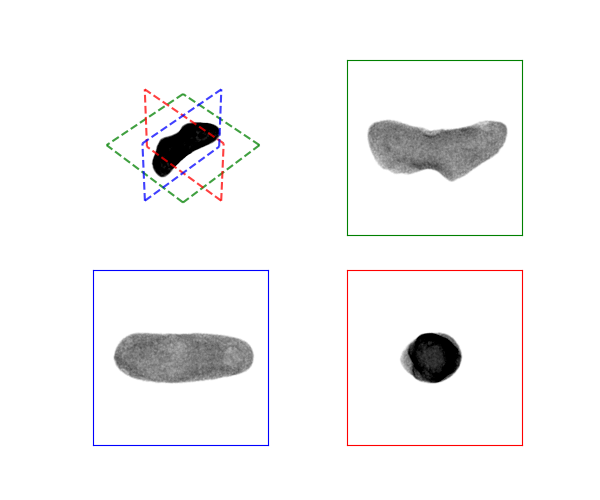

In [3]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses)

# Representing the asteroid mass distribution via a neural network


## 1 - Defining the network architecture
We here use functions from our module as to not clutter the notebook, but the code is rather straight forward: a FFNN with some options.

In [4]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN network (FFNN with sin non linearities and a final sigmoid to predict the density)
model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.AbsLayer())

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [5]:
## IF YOU WANT TO LOAD AN ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail

#model.load_state_dict(torch.load("model.mdl"))

# Once a model is loaded the learned constant c (named kappa in the paper) is unknown 
# and must be relearned (ideally it should also be saved at the end of the training as it is a learned parameter)
#c = gravann.compute_c_for_model(model, encoding, mascon_points, mascon_masses, use_acc = True)

## 2 - Visualizing the initial neural density field
The network output is a mass density in the unit cube. Essentially a three dimensional function which we here plot via rejection sampling (for now this method is good enough)

Sampling points...: 10132it [00:09, 1068.42it/s]                                                                       


<IPython.core.display.Javascript object>


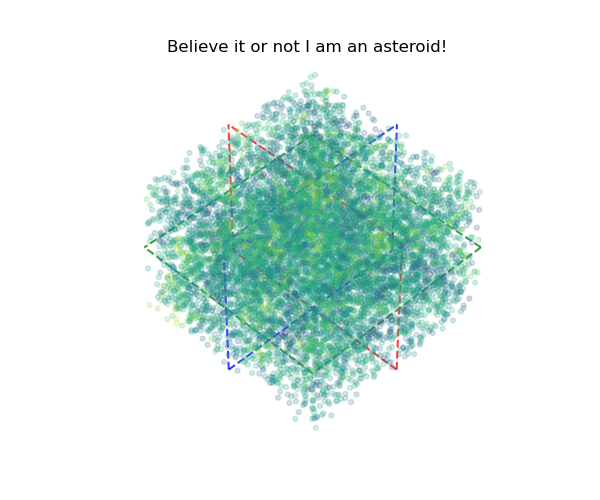

Text(0.5, 0.92, 'Believe it or not I am an asteroid!')

In [6]:
# The rejection plot will visualize the neural density field as a probability distribution function. 
# Colors represent the density magnitude (white being zero). 
# At the beginning, the whole hypercube is filled with some non vanishing density.
gravann.plot_model_rejection(model, encoding, views_2d=False, N=10000, progressbar=True, c=1)
plt.title("Believe it or not I am an asteroid!")

# Training of a gravityAnn

In [7]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Number of points to be used to evaluate numerically the triple integral
# defining the acceleration. 
# Use <=30000 to for a quick training ... 300000 was used to produce most of the paper results
n_quadrature = 300000

# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
# Use 100 for a quick training. 1000  was used to produce most of the paper results
batch_size = 100

# Loss. The normalized L1 loss (kMAE in the paper) was
# found to be one of the best performing choices.
# More are implemented in the module
loss_fn = gravann.normalized_L1_loss

# The numerical Integration method. 
# Trapezoidal integration is here set over a dataset containing acceleration values,
# (it is possible to also train on values of the gravity potential, results are similar)
mc_method = gravann.ACC_trap

# The sampling method to decide what points to consider in each batch.
# In this case we sample points unifromly in a sphere and reject those that are inside the asteroid
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/Eros_lp.pk", 
                                                         method="spherical", 
                                                         bounds=[0,1])
# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience = 200, min_lr = 1e-6,verbose=True)

# And init the best results
best_loss = np.inf
best_model_state_dict = model.state_dict()

**Note: the cell below is explicitly typed for convenience, as this is a tutorial-ish after all, but the module gravann contains a function (train_on_batch) that does the same**

In [8]:
# TRAINING LOOP (normal training, no use of any prior shape information)------------------------
# This cell can be stopped and started again without loosing memory of the training nor its logs
torch.cuda.empty_cache()
# The main training loop
for i in range(5000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
        # We compute the labels whenever the target points are changed
        labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
    
    # We compute the values predicted by the neural density field
    predicted = mc_method(target_points, model, encoding, N=n_quadrature)
    
    # We learn the scaling constant (k in the paper)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    
    # We compute the loss (note that the contrastive loss needs a different shape for the labels)
    if loss_fn == gravann.contrastive_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    
    # We store the model if it has the lowest fitness 
    # (this is to avoid losing good results during a run that goes wild)
    if loss < best_loss:
        best_model_state_dict = model.state_dict()
        best_loss = loss
        print('New Best: ', loss.item())
    
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((n_quadrature*batch_size) // 1000)
    
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
        
    # Zeroes the gradient (necessary because of things)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

New Best:  0.37840840220451355
It=0	 loss=3.784e-01	  weighted_average=3.784e-01	  c=6.276e+00
New Best:  0.3204638957977295
New Best:  0.2840244174003601
New Best:  0.25699540972709656
New Best:  0.24634690582752228
New Best:  0.23188169300556183
New Best:  0.1746198982000351
New Best:  0.16571101546287537
New Best:  0.14183181524276733
New Best:  0.13061121106147766
New Best:  0.11442556977272034
New Best:  0.11168187856674194
New Best:  0.10887039452791214
New Best:  0.08395218104124069
It=25	 loss=8.395e-02	  weighted_average=1.832e-01	  c=1.082e+01
New Best:  0.07255081087350845
New Best:  0.0690804272890091
New Best:  0.059478361159563065
New Best:  0.04513263702392578
New Best:  0.0430990532040596
New Best:  0.04011571407318115
New Best:  0.03370415046811104
New Best:  0.03119705244898796
New Best:  0.027521798387169838
New Best:  0.022820770740509033
It=50	 loss=4.706e-02	  weighted_average=3.820e-02	  c=9.170e+00
New Best:  0.020896509289741516
New Best:  0.020076140761375427


It=2225	 loss=4.587e-03	  weighted_average=4.776e-03	  c=9.006e+00
It=2250	 loss=3.942e-03	  weighted_average=3.736e-03	  c=9.145e+00
It=2275	 loss=2.362e-03	  weighted_average=4.345e-03	  c=9.145e+00
It=2300	 loss=2.943e-03	  weighted_average=2.037e-03	  c=9.037e+00
Epoch  2302: reducing learning rate of group 0 to 2.0972e-05.
It=2325	 loss=3.942e-03	  weighted_average=2.883e-03	  c=9.012e+00
It=2350	 loss=1.984e-03	  weighted_average=3.042e-03	  c=8.972e+00
It=2375	 loss=2.673e-03	  weighted_average=2.354e-03	  c=8.982e+00
It=2400	 loss=3.813e-03	  weighted_average=2.436e-03	  c=9.075e+00
It=2425	 loss=3.336e-03	  weighted_average=2.687e-03	  c=8.935e+00
It=2450	 loss=2.104e-03	  weighted_average=2.465e-03	  c=8.990e+00
It=2475	 loss=2.127e-03	  weighted_average=1.953e-03	  c=8.955e+00
New Best:  0.0009491518139839172
It=2500	 loss=5.279e-03	  weighted_average=1.655e-03	  c=8.937e+00
It=2525	 loss=1.818e-03	  weighted_average=3.610e-03	  c=9.015e+00
It=2550	 loss=2.101e-03	  weighted

It=4900	 loss=4.688e-03	  weighted_average=1.180e-03	  c=9.251e+00
It=4925	 loss=1.359e-03	  weighted_average=2.008e-03	  c=9.270e+00
It=4950	 loss=2.710e-03	  weighted_average=1.105e-03	  c=9.281e+00
It=4975	 loss=2.405e-03	  weighted_average=1.922e-03	  c=9.263e+00


In [9]:
# Here we restore the learned parameters of the best model of the run
for layer in model.state_dict():
    model.state_dict()[layer] = best_model_state_dict[layer]

# Interpretation of the neural density field learned

<IPython.core.display.Javascript object>


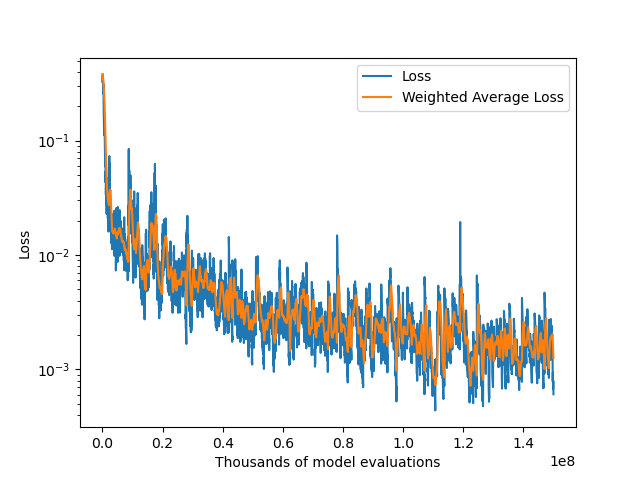

In [10]:
# First lets have a look at the training loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa, loss_log)
plt.semilogy(abscissa, weighted_average_log)
plt.xlabel("Thousands of model evaluations")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

Sampling points...: 1562it [00:02, 707.42it/s]                                                                         


<IPython.core.display.Javascript object>


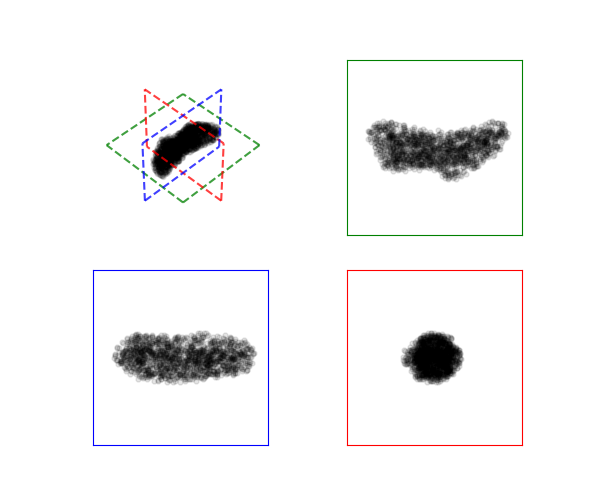

In [11]:
# Lets have a look at the neural density field.
# First with a rejection plot
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=c, crop_p=0.1, progressbar=True)

Sampling points...: 2578it [00:03, 717.52it/s]                                                                         


<IPython.core.display.Javascript object>


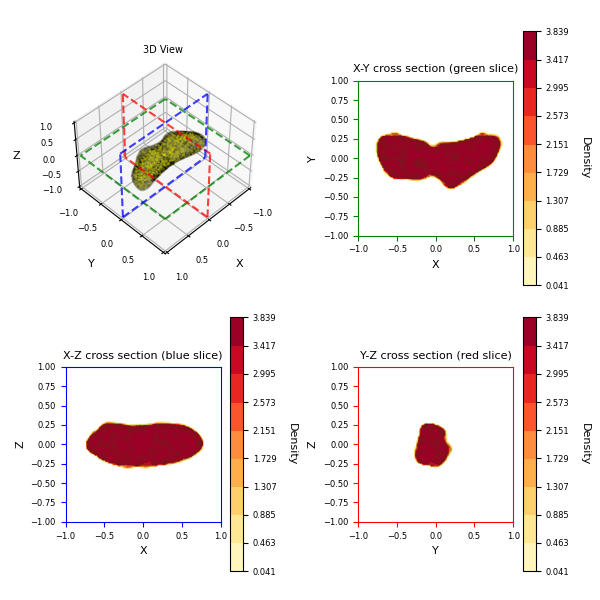

<Axes3DSubplot:title={'center':'3D View'}, xlabel='X', ylabel='Y'>

In [12]:
# Then overlaying a heatmap to the mascons 
gravann.plot_model_vs_mascon_contours(model, encoding, mascon_points, mascon_masses,c=c, progressbar = True, N=2500, heatmap=True)

In [13]:
# Computes the Validation table with rel and abs errors on the predicted acceleration (w.r.t. ground truth) 
# at low, med, high altitudes (see paper). is requires sampling quite a lot, so it takes time 
gravann.validation(model, encoding, mascon_points, mascon_masses, use_acc=True, asteroid_pk_path="3dmeshes/Eros.pk", N=1000, N_integration=5000, batch_size=32, progressbar=True)

Computing validation...:  93%|█████████████████████████████████████████████▊   | 44128/47244 [00:27<00:01, 1611.26it/s]

Discarding 4193 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  96%|███████████████████████████████████████████████▉  | 45280/47244 [00:47<00:08, 228.34it/s]

Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  98%|█████████████████████████████████████████████████▉ | 46272/47244 [01:27<00:22, 42.59it/s]

Discarding 11243 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 47264it [01:34, 498.51it/s]                                                                   


,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.456716,0.302225,2.089442,0.446917
1,High Altitude,0.154829,0.120987,0.593145,0.147543
2,Altitude_0,0.164746,0.125797,0.543842,0.138119
3,Altitude_1,0.083121,0.077858,0.270144,0.084630
4,Altitude_2,0.023171,0.035156,0.075028,0.037477


Sampling points at altitude
Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.
Got  5000  points.
Splitting in left / right hemisphere
Left:  2413  points.
Right:  2587  points.


<IPython.core.display.Javascript object>


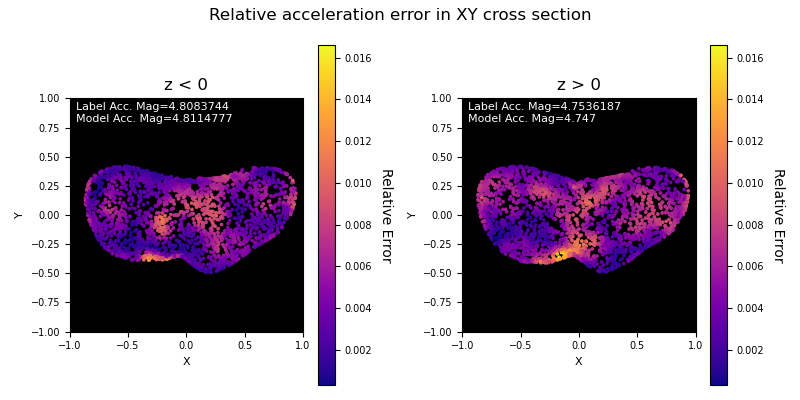

(<AxesSubplot:title={'center':'z > 0'}, xlabel='X', ylabel='Y'>,
 tensor([[-2.4657,  1.2089, -0.4078],
         [-1.1817, -2.2814, -0.7141],
         [ 2.6594, -0.1282, -0.9586],
         ...,
         [-0.5479, -2.9673, -1.0471],
         [-0.3059, -2.6974, -2.3302],
         [ 0.5721,  0.9003, -3.2602]]))

In [14]:
# Shows how the relative error is distribued along the asteroid surface (at some altitude) 
gravann.plot_model_mascon_acceleration("3dmeshes/Eros.pk", model, encoding, mascon_points, mascon_masses, plane="XY", c=c, N=5000, logscale=False, altitude=0.1)

<IPython.core.display.Javascript object>


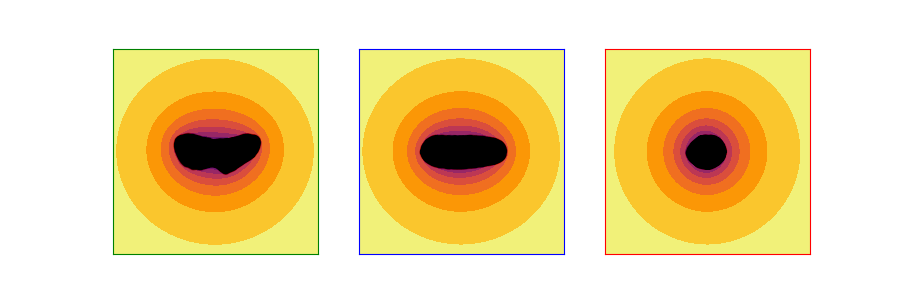

<AxesSubplot:>

In [15]:
# Shows the Contour plot of the gravity potential generated by the neural density field.
gravann.plot_potential_contours(model, encoding, mascon_points)

#### Saving the model

In [16]:
# Uncomment to save the model
#torch.save(model.state_dict(), "model.mdl")